## Project Dependencies

#### Prerequisites


In [ ]:
!pip install dotenv tqdm sentence-transformers 

In [ ]:
from time import sleep

import requests
import json
import pandas as pd
import time
from collections import defaultdict
from datetime import datetime

from dotenv import load_dotenv
import os


In [ ]:
load_dotenv(dotenv_path='app.env')

token = os.getenv('GITHUB_TOKEN')

In [34]:
#Output
project_dataset_path = "dataset/Project_Data"
package_dataset_path = "dataset/Package_Data"


project_dependencies_json = f"{project_dataset_path}/Project_dependencies_50_topics.json"
project_details_csv = f"{project_dataset_path}/Github_Project_Details_50_Topic.csv"

package_dependencies_json = f"{package_dataset_path}/package-features.json"
package_features_cf_json = f"{package_dataset_path}/package-feats-cf.json"

In [ ]:
# Read the CSV file
file_path = 'dataset/Application_types.csv'
df = pd.read_csv(file_path)

# Convert the 'Keyword' column to a list
topic_list = df['Keyword'].tolist()

# Display the list
print(topic_list)


def write_json_data(fileName, data):
    with open(fileName, 'w') as file:
        json.dump(data, file, indent=4)


def append_json_data(fileName, data):
    # Try to read existing data if the file exists
    try:
        with open(fileName, 'r') as file:
            existing_data = json.load(file)
    except FileNotFoundError:
        existing_data = []  # Initialize as an empty list if the file doesn't exist

    # Append new data to existing data
    existing_data.append(data)

    # Write the updated data back to the file
    with open(fileName, 'w') as file:
        json.dump(existing_data, file, indent=4)


def sleep_if_rate_exhausted(response):
    core_limits = response.headers._store
    rate_left = core_limits['x-ratelimit-remaining'][1]

    if int(rate_left) > 0:
        return

    reset_time = core_limits['x-ratelimit-reset'][1]
    reset_timestamp = datetime.fromtimestamp(int(reset_time))
    current_time = datetime.now()
    sleep_duration = (reset_timestamp - current_time).total_seconds()
    print(f"Rate limit reached. Sleeping until reset at {reset_timestamp}")
    time.sleep(sleep_duration+5)  # Sleep until reset time + some delay time
    print("Rate limit reset. Resuming requests.")


In [ ]:
def get_github_projects_of_topic(num_results,num_pages, topic):
    headers = {'Authorization': f'token {token}'}
    url = 'https://api.github.com/search/repositories'
    params = {
        'q': f'language:JavaScript {topic} stars:>50',
        'sort': 'stars',
        'order': 'desc',
        'per_page': num_results,
        'page': num_pages
    }

    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        projects = [
            {
                'id': item['id'],
                'name': f"{item['name']}+{item['owner']['login']}",  # Combine name and owner
                'owner': item['owner']['login'],  # Keep the owner column
                'watchers': item['watchers_count'],
                'created_at': item['created_at'],
                'updated_at': item['updated_at'],
                'size': item['size'],
                'stars': item['stargazers_count'],
                'open_issues_count': item['open_issues_count'],
                'language': item['language'],
                'forks': item['forks'],
                'description': item['description'],
                'topics': item['topics']
            } 
            for item in data['items']
        ]
        
        
        
        for project in projects:
            if project['id'] in projects_set:
                continue
            
            unique_projects.append(project)
            projects_set.add(project['id'])
            if(len(unique_projects) >= total_num_results):
                break

        

        return unique_projects, response,len(unique_projects),len(projects)

    else:
        print(f"Error: {response.status_code}")
        return None, response

topic_dict = {}
num_topics = 50
projects_set = set()
for i in range(num_topics):
    currentTopic = topic_list[i]
    num_unique_results = 0
    num_pages=1
    unique_projects = []
    prev_results=0
    num_results = 10
    total_num_results = num_results
    while True:
        projects, response, num_unique_results, num_of_results_from_API = get_github_projects_of_topic(num_results=num_results, num_pages=num_pages,topic=currentTopic)
        
        if projects is not None:
            topic_dict[currentTopic] = projects
        
        if num_unique_results >= total_num_results:
            break
        
        if num_of_results_from_API == prev_results:
            break
        
        prev_results = num_of_results_from_API
        
        if num_results<100:
            num_results+=10
        else:
            num_pages+=1
        
        
        sleep_if_rate_exhausted(response)
        
    sleep_if_rate_exhausted(response)
    
        
    
        

print(topic_dict)








In [ ]:
def get_Sbom_of_projects(repo_df):
    headers = {'Authorization': f'token {token}'}
    url = 'https://api.github.com/repos/'
    owner = repo_df['owner']
    repo_name_owner = repo_df['name']
    repo = repo_df['name'].split('+')[0]
    url = url + f'{owner}/{repo}/dependency-graph/sbom'

    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        packages = data['sbom']['packages']
        # Extract npm packages with name and version
        pkg_dict = defaultdict(dict)
        data_written = False
        for package in packages:
            if package['externalRefs'][0]['referenceLocator'].startswith('pkg:npm'):
                try:
                    if len(package['versionInfo']) > 0:
                        if 'versionInfo' in package:
                            if package['name'].startswith('npm:'):
                                data_written = True
                                sbom_dict[repo_name_owner][package['name'][4:]] = package['versionInfo']
                            else:
                                data_written = True
                                sbom_dict[repo_name_owner][package['name']] = package['versionInfo']
                except:
                    continue
        
        if not data_written:
            print(repo_df)
            print(packages[0]['externalRefs'][0]['referenceLocator'])
            remove_projects.append(repo_df)
    else:
        print(f"Error: {response.status_code}")
        remove_projects.append(repo_df)

    return response


remove_projects = []
sbom_dict = defaultdict(dict)
ctr = tctr = 1
for topic, projects in topic_dict.items():
    for project in projects:
        response = get_Sbom_of_projects(project)
        sleep_if_rate_exhausted(response)
    print(f'{ctr}. {topic} done')
    ctr+=1



In [ ]:
os.makedirs(project_dataset_path, exist_ok=True)
write_json_data(project_dependencies_json, sbom_dict)

In [ ]:
print(len(remove_projects))


def check_if_in_remove(project_id):
    for i in remove_projects:
        if i['id'] == project_id:
            return True
    return False

In [ ]:
all_projects = []

filename = project_details_csv
for topic, projects in topic_dict.items():
    for project in projects:
        # Add the topic as a new field in each project dictionary
        if(not (check_if_in_remove(project["id"]))):
            project['topic'] = topic
            all_projects.append(project)
        else:
            print(project)

# Convert the list of all projects with topics into a DataFrame
df = pd.DataFrame(all_projects)

# Save the DataFrame to a CSV file
df.to_csv(f'{filename}', index=False)

print(f"Data saved to {filename}.csv")

## Package Dependencies

In [ ]:
import json
import math
from collections import defaultdict

import pandas as pd
import requests
from tqdm.notebook import tqdm
import threading
from concurrent.futures import ThreadPoolExecutor, as_completed

In [ ]:
def filter_valid_package_names(packages):
    packages = set(packages)
    remove = set()
    for package in packages:
        if (not package.startswith('@')) and (not package[0].islower()):
            remove.add(package)
                
    return packages - remove

# test function
print(filter_valid_package_names({'../cli', 'axios', '@blah/blah', '345'}))

In [ ]:
def create_package_space_from_project_json(filepath):
    package_space = set()
    project_data = json.load(open(filepath))
    for _, deps in project_data.items():
        for pkg in deps.keys():
            if pkg.startswith("npm:"):
                pkg = pkg[4:]
            package_space.add(pkg)
            
    return package_space

In [ ]:
from bs4 import BeautifulSoup
import os

def create_package_list():
    res = requests.get("https://gist.github.com/anvaka/8e8fa57c7ee1350e3491")
    if res.status_code == 200:
        parsed_html = BeautifulSoup(res.content, "html.parser")
        selector = "#gistcomment-4447488 > div.edit-comment-hide > task-lists > div > p:nth-child(3)"
        package_list = parsed_html.select(selector)
        with open("./playground/package_list.txt", "w") as f:
            f.write(package_list[0].text)
            
def load_package_list():
    if not os.path.exists("./playground/package_list.txt"):
        create_package_list()
    else:
        with open("./playground/package_list.txt", "r") as f:
            return [text for text in f.read().splitlines()]
    
def create_package_space_from_github_gist():
    # packages = load_package_list()
    # print(len(packages))
    return set(load_package_list())
    
                
print(len(create_package_space_from_github_gist()))

In [ ]:
pkg_space = create_package_space_from_project_json(project_dependencies_json)
print("Number of packages:", len(pkg_space))

In [ ]:
from datetime import datetime, timedelta

def convert_time_to_epoch(timestamp):
    timestamp = timestamp.replace('Z', '+00:00')
    timestamp = datetime.fromisoformat(timestamp)
    return datetime.strftime(timestamp, '%s')
    

In [ ]:
def fetch_package_data(package, base_url="https://registry.npmjs.org/", max_retries=3):
    for attempt in range(max_retries):
        try:
            res = requests.get(base_url + package)
            data = res.json()
            
            if res.status_code == 200:
                if 'dist-tags' not in data:
                    print(f"{package} is unpublished")
                    return {}
            
                latest_version = data["dist-tags"]["latest"]
                
                package_details = {
                    "latest_version": latest_version,
                    "keywords": data.get("keywords", []),
                    "publish_time": convert_time_to_epoch(data["time"][latest_version]),
                    "description": data.get("description", ""),
                    "creation_date": data["time"]["created"],
                    "number_of_versions": len(data["versions"]),
                    "dependencies": data["versions"][latest_version].get("dependencies", {}), 
                    "devDependencies": data["versions"][latest_version].get("devDependencies", {}), 
                    "peerDependencies": data["versions"][latest_version].get("peerDependencies", {}), 
                }
                
                return package_details
            
            else:
                # print(f"{package} failed with status code {res.status_code}")
                return -res.status_code
                
        except requests.exceptions.ConnectionError as ce:
            if attempt < max_retries - 1:
                print(f"Failed to fetch {package} due to connection error: attempt {attempt + 1}")
            else:
                print("Failed to fetch {package}: max attempts exceeded")
                return {}
        except Exception as e:
            print("EXCEPTION OCCURED", package, e)

In [ ]:
fetch_package_data("@types/recordrtc")

In [ ]:
def limit_package_space(full_space, n):
    limit_space = set()
    for _ in range(n):
        limit_space.add(full_space.pop())
    return limit_space

In [ ]:
def build_package_space(max_workers=20, max_iters=2, test_mode=False, src='project'):
    package_space = []
    iter_log = defaultdict(list)
    
    if src == 'github':
        package_space = create_package_space_from_github_gist()
    elif src == 'project':
        package_space = create_package_space_from_project_json(project_dependencies_json)
        
    
    if test_mode:
        package_space = limit_package_space(package_space, 20)
        
    package_space = filter_valid_package_names(package_space)
    
    fetched = set()
    package_features = dict()
    dep_graph = dict()
    
    feat_lock = threading.Lock()
    graph_lock = threading.Lock()
    fetched_lock = threading.Lock()
    
    data_fields = [
        "latest_version",
        "keywords",
        "publish_time",
        "description",
        "creation_date", 
        "number_of_versions"
    ]
    
    # THIS CODE IS FOR IF WE WANT TO INCLUDE MULTIPLE DEPENDENCY TYPES
    # ----------------------------------------------------------------
    # dep_types = [
    #     ("dependencies", "PROD"), 
    #     ("devDependencies", "DEV"), 
    #     ("peerDependencies", "PEER")
    # ]
    
    next_iter = set()
    next_iter.update(package_space)
    # print(next_iter)
    
    curr_iter = 1
    
    while (max_iters == -1 and len(next_iter) > 0) or curr_iter <= max_iters:
        package_set, next_iter = next_iter, set()
        
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = { executor.submit(fetch_package_data, package): package for package in package_set }
            
            try: 
                for future in tqdm(as_completed(futures), total=len(futures), desc=f'Iteration {curr_iter}'):
                    pkg = futures[future]
                    package_data = future.result()
                    
                    with fetched_lock:
                        fetched.add(pkg)
                        
                    if type(package_data) == type(0) and package_data < 0:
                        iter_log[curr_iter].append(f'{pkg} failed with status code {package_data}')
                    
                    elif package_data != {}:
                        with feat_lock, graph_lock:
                            package_features[pkg] = {field: package_data[field] for field in data_fields}
                            deps = {d: package_data["dependencies"][d] for d in filter_valid_package_names(package_data["dependencies"])}
                            dep_graph[pkg] = list(deps.keys())
                            next_iter.update(deps.keys())
    
                            # THIS CODE IS FOR IF WE WANT TO INCLUDE MULTIPLE DEPENDENCY TYPES
                            # ----------------------------------------------------------------
                            # dep = dict()
                            # for d_type, code in dep_types:
                            #     for d,v in package_data[d_type].items():
                            #         dep[d] = (v, code)
                            #         
                            # dep_graph[pkg] = dep
                            # 
                            # next_iter.update(package_data["dependencies"].keys())
                            # next_iter.update(package_data["devDependencies"].keys())
                            # next_iter.update(package_data["peerDependencies"].keys())
                        
            except Exception as e:
                # print(e)
                iter_log[curr_iter].append(e)
                
        next_iter.difference_update(fetched)
        
        print(f"Failed in current iteration - {curr_iter + 1}: {len(iter_log[curr_iter])} packages. Check log.txt for details")
        print(f"Next Iteration - {curr_iter + 1}: {len(next_iter)} packages")
        curr_iter += 1
        
    # Output log
    with open("log.txt", "w") as f:
        for i in range(1,curr_iter):
            f.write(f"============= Iteration {i} =============\n")
            f.writelines('\n'.join(iter_log[i-1]))
            
    return package_features, dep_graph
            

In [ ]:
feats, graph = build_package_space(max_iters=-1)

In [ ]:
def retryable_request(func, *args, max_retries=10, fail_value=None, **kwargs,):
    for i in range(max_retries):
        try:
            return func(*args, **kwargs)
        except requests.exceptions.ConnectionError as ce:
            if i < max_retries - 1:
                print(f"Failed request {func} {args} {kwargs} due to connection error: attempt {i + 1}")
            else:
                print(f"Failed to fetch {package}: max attempts exceeded")
                return fail_value

def get_download_counts_bulk(packages):
    url = f"https://api.npmjs.org/downloads/point/last-year/{','.join(packages)}"
    res = requests.get(url)
    
    if res.status_code == 200:
        data = res.json()
        return [(p, d['downloads']) for p,d in data.items()]
        
    else:
        print(f"[ERROR] failed for chunk {packages} with status code {res.status_code}")
        return -1
        
get_download_counts_bulk(["semver", "axios"])

def get_download_count(package):
    url = f"https://api.npmjs.org/downloads/point/last-year/{package}"
    res = requests.get(url)
    
    if res.status_code == 200:
        data = res.json()
        return data['downloads']
    
    else:
        print(f"[ERROR] failed for package {package} with status code {res.status_code}")
        return -1
      
# Test  
print(get_download_counts_bulk(["semver", "axios"]))
print(get_download_count("semver"))

retryable_request(get_download_count, "semver")

In [ ]:
# divide into scoped and unscoped packages
def fetch_download_counts_unscoped(packages, max_workers=5):
    chunks = []
    for i in range(0, len(packages), 128):
        chunks.append(packages[i:i + 128])
    print("Number of chunks for unscoped:", len(chunks))
    
    counts = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = { executor.submit(retryable_request, get_download_counts_bulk, chunk): chunk for chunk in chunks }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Unscoped packages"):
            res = future.result()
            if res != -1:
                counts += res
            
    return counts
    
def fetch_download_counts_scoped(packages, max_workers=5):
    counts = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = { executor.submit(retryable_request, get_download_count, package): package for package in packages }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Scoped Packages"):
            res = future.result()
            if res != -1:
                counts.append((futures[future], res))
                
    return counts


def fetch_download_counts(packages, max_workers_unscoped=5, max_workers_scoped=5):
    scoped = []
    unscoped = []
    for package in packages:
        if package.find("@") != -1:
            scoped.append(package)
        else:
            unscoped.append(package)
    print(f'scoped: {len(scoped)}\tunscoped: {len(unscoped)}')
    
    counts = fetch_download_counts_unscoped(unscoped, max_workers=max_workers_unscoped)
    counts += fetch_download_counts_scoped(scoped, max_workers=max_workers_scoped)

    return counts

def update_download_counts(features_dict):
    counts = fetch_download_counts(list(features_dict.keys()), max_workers_scoped=10)
    for p, c in counts:
        features_dict[p]["download_count"] = c
    
# Test function
fetch_download_counts(["semver", "axios", "@vue/cli-plugin-unit-mocha"])

In [ ]:
update_download_counts(feats)

In [ ]:
def save_dataset(features, edges, feature_filename=package_dependencies_json, edges_filename="./dataset/dep-graph.json"):
    with open(feature_filename, "w") as feat_file:
        print(f"Saving features to {feature_filename}")
        json.dump(features, feat_file, indent=4)
    with open(edges_filename, "w") as edge_file:
        print(f"Saving edges to {edges_filename}")
        json.dump(edges, edge_file, indent=4)
        
save_dataset(feats, graph)

In [ ]:
def load_dataset(feature_filename=package_dependencies_json, edges_filename="./dataset/dep-graph.json"):
    feats = json.load(open(feature_filename, "r"))
    edges = json.load(open(edges_filename, "r"))
    return feats, edges

In [ ]:
def clean_graph(graph, valid):
    for p in graph.keys():
        if p not in valid:
            del graph[p]
            
        else:
            graph[p] = [p for p in graph[p] if p in valid]

In [ ]:
feats, graph = load_dataset()

In [ ]:
clean_graph(graph, feats.keys())

In [ ]:
edges = []

for package, deps in graph.items():
    if len(deps) > 0:
        for dep in deps:
            edges.append((package, dep))

headers = ['package', 'dependency']
df = pd.DataFrame(edges, columns=headers)
df.head()

In [ ]:
df.to_csv("./dataset/dep-graph.csv", index=False)

In [ ]:
feat_data = []
headers = ['package', 'latest_version', 'keywords', 'publish_time', 'description', 'creation_date', 'number_of_versions', 'download_count']
for package, feats in feats.items():
    feat_data.append([package] + list(feats.values()))

feat_df = pd.DataFrame(feat_data, columns=headers)
feat_df.head()

In [ ]:
feat_df.to_csv("./dataset/package-feats.csv", index=False)

## Memory Based CF

In [35]:
import pandas as pd
import numpy as np
import networkx as nx
import json
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [49]:
# Load data
package_feats = json.load(open(package_dependencies_json))
project_data = json.load(open(project_dependencies_json))

In [50]:
# For each project remove dependencies that are not available
def clean_project_data(data, valid):
    for project, deps in data.items():
        data[project] = [p for p in deps.keys() if p in valid]
        
clean_project_data(project_data, package_feats.keys())

In [51]:
def create_package_list(data):
    packages = set()
    for deps in data.values():
        packages.update(deps)
    return list(packages)

In [59]:
def create_ground_truth_matrix(data):
    package_list = create_package_list(project_data)
    package_list.sort()
    project_names = sorted(data.keys())
    
    gt_mat = np.zeros((len(project_names), len(package_list)))
    
    for i, project in enumerate(project_names):
        for pkg in data[project]:
            if pkg in package_list:
                j = package_list.index(pkg)
                gt_mat[i, j] = 1
                    
    return gt_mat, package_list, project_names
                
ground_truth, package_order, project_order = create_ground_truth_matrix(project_data)

In [9]:
print(ground_truth.shape)

(405, 12266)


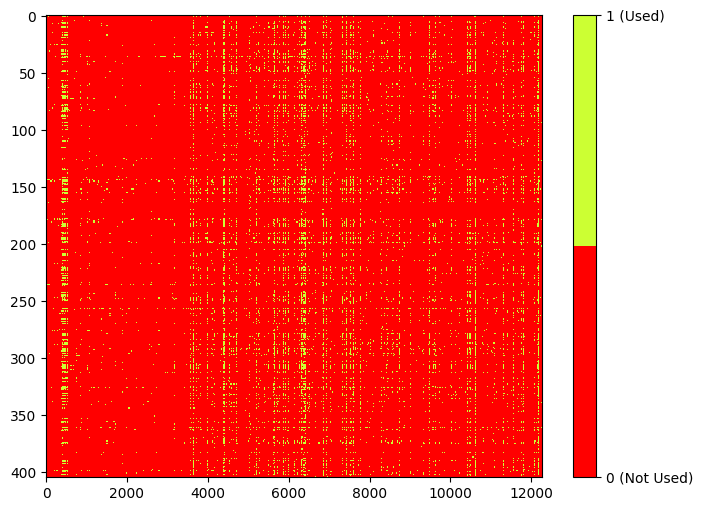

In [60]:
def visualize_matrix(mat, mask=None, colors=('#023047', 'red', '#ccff33')):
    if mask is None:
        mat_display = mat
        cmap = ListedColormap(colors[1:])
        yticks = [0, 1]
        yticklabels = ['0 (Not Used)', '1 (Used)']
    else:
        mat_display = mat.copy()
        mat_display[mask == 0] = -1
        cmap = ListedColormap(colors)
        yticks = [-1, 0, 1]
        yticklabels = ['-1 (Blank)', '0 (Not Used)', '1 (Used)']
        
    plt.figure(figsize=(8, 6))
    plt.imshow(mat_display, cmap=cmap, interpolation='nearest', aspect='auto')
    
    cbar = plt.colorbar(ticks=yticks)
    cbar.ax.set_yticklabels(yticklabels)
    
    plt.show()
    
visualize_matrix(ground_truth)
        

In [61]:
np.random.seed(42)  # For reproducibility

# Function to mask a percentage of values
def mask_matrix(matrix, mask_percentage):
    masked_matrix = matrix.copy()
    total_elements = matrix.size
    num_to_mask = int(total_elements * mask_percentage / 100)
    
    # Get random indices to mask
    indices = np.random.choice(total_elements, num_to_mask, replace=False)
    rows, cols = np.unravel_index(indices, matrix.shape)
    
    # Mask selected values
    masked_matrix[rows, cols] = np.nan  # Replace with 0 (or np.nan if preferred)
    return masked_matrix

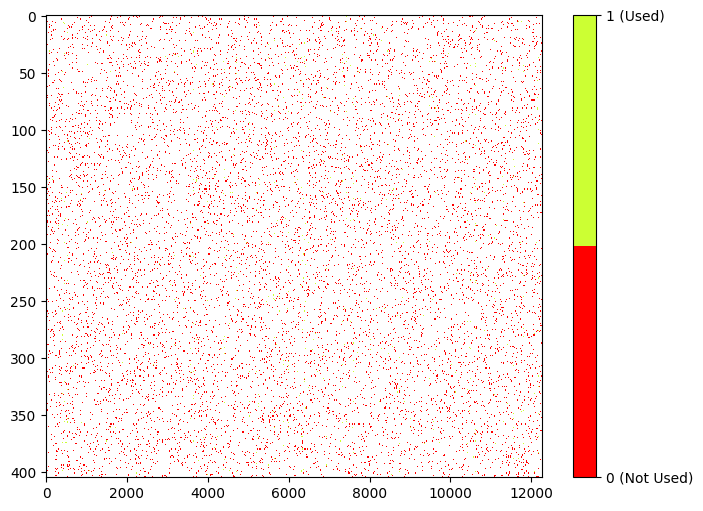

In [62]:
training_matrix = mask_matrix(ground_truth, 95)
visualize_matrix(training_matrix)

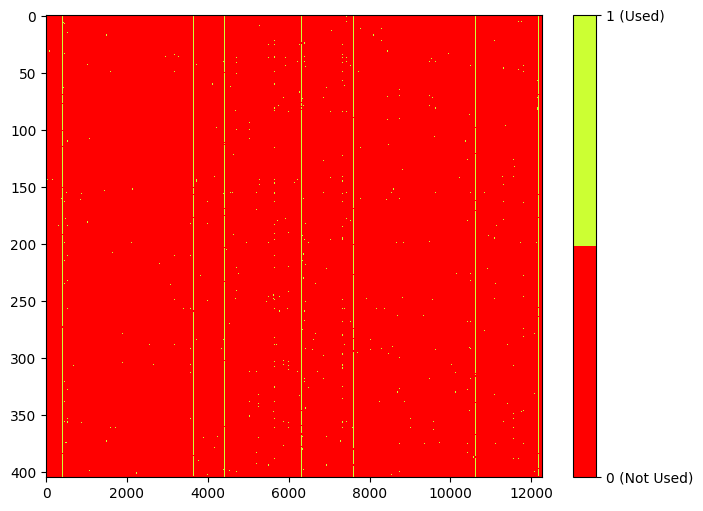

In [63]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def predict_with_collaborative_filtering(training_matrix, similarity_type):
    matrix = training_matrix.copy()
    
    nan_mask = np.isnan(matrix)
    matrix[nan_mask] = 0
    
    if similarity_type == 'item':
        similarity = cosine_similarity(matrix.T)  # Item-item similarity
        mean_ratings = np.nanmean(training_matrix, axis=0)  # Item-wise mean
        prediction = np.dot(matrix, similarity) / (np.abs(similarity).sum(axis=1) + 1e-8)
    elif similarity_type == 'user':
        similarity = cosine_similarity(matrix)  # User-user similarity
        mean_ratings = np.nanmean(training_matrix, axis=1)  # User-wise mean
        prediction = np.dot(similarity, matrix) / (np.abs(similarity).sum(axis=1)[:, np.newaxis] + 1e-8)
    
    if similarity_type == 'item':
        prediction += mean_ratings[np.newaxis, :]
    else:
        prediction += mean_ratings[:, np.newaxis]
    
    training_matrix[nan_mask] = prediction[nan_mask]
    return training_matrix

predicted_matrix = predict_with_collaborative_filtering(training_matrix, similarity_type='item')

visualize_matrix(predicted_matrix)

In [64]:
def reconstruction_error(original, test):
    
    # Apply the mask to calculate the error only on specified elements
    difference = original - test
    squared_error = np.square(difference)
    mean_squared_error = np.mean(squared_error)
    rmse = np.sqrt(mean_squared_error)
    
    return rmse


In [65]:
reconstruction_error(ground_truth, predicted_matrix)

np.float64(0.19035422224138585)

## Matrix CF

In [66]:
np.random.seed(42)

def create_observation_mask(M, mask_percentage):
    n, m = M.shape
    total_entries = n * m
    mask_count = int(mask_percentage * total_entries / 100)

    # Randomly shuffle indices
    all_indices = np.arange(total_entries)
    np.random.shuffle(all_indices)

    # Select indices to retain
    mask_indices = all_indices[:mask_count]

    # Create observation mask
    O = np.ones_like(M, dtype=int)
    O.flat[mask_indices] = 0
    return O


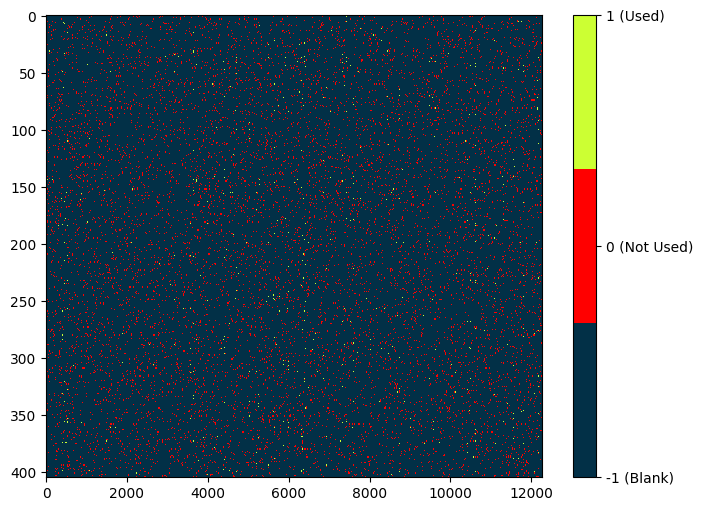

In [67]:
obs_mask = create_observation_mask(ground_truth, mask_percentage=95)
visualize_matrix(ground_truth, mask=obs_mask)

In [68]:
from IPython.display import clear_output

def collaborative_filtering(M, O, Otest, Mgt, lambdaNuc_factor=4, lambdaDF=1e1, max_iter=2000, tol=1e-1):
    # Initialization
    n, m = M.shape
    OM = O * M
    normOM = np.linalg.norm(OM, 2)
    lambdaNuc = normOM / lambdaNuc_factor
    
    # Identify zero rows and columns
    idx_zero_cols = np.where(np.sum(O, axis=0) < 1e-9)[0]
    idx_zero_rows = np.where(np.sum(O, axis=1) < 1e-9)[0]
    nb_zero_cols = len(idx_zero_cols)
    nb_zero_rows = len(idx_zero_rows)
    
    X = M.copy()
    Xb = X.copy()
    Y = np.zeros_like(M)
    normA = 1.0
    sigma = 1.0 / normA
    tau = 1.0 / normA
    diffX = 1e10
    min_nm = np.min([n, m])
    k = 0

    def shrink(S, thresh):
        return np.maximum(S - thresh, 0) - np.maximum(-S - thresh, 0)
    
    # Iterative process
    while k < max_iter and diffX > tol:
        k += 1
        
        # Update dual variable Y
        Y = Y + sigma * Xb
        U, S, V = np.linalg.svd(Y / sigma, full_matrices=False)
        Sdiag = shrink(S, lambdaNuc / sigma)
        Sshrink = np.zeros_like(M)
        for i in range(len(Sdiag)):
            Sshrink[i, i] = Sdiag[i]
        Y = Y - sigma * (U @ np.diag(Sdiag) @ V)
        
        # Update primal variable X
        Xold = X.copy()
        X = X - tau * Y
        X = (X + tau * lambdaDF * O * M) / (1 + tau * lambdaDF * O)
        
        # Fix issues with rows/columns with no observations
        r, c = np.where(X > 0.0)
        median = np.median(X[r, c]) if len(r) > 0 else 0
        if nb_zero_cols > 0:
            X[:, idx_zero_cols] = median
        if nb_zero_rows > 0:
            X[idx_zero_rows, :] = median
        
        # Update primal variable Xb
        Xb = 2 * X - Xold
        
        # Difference between iterations
        diffX = np.linalg.norm(X - Xold)
        
        # Reconstruction error
        err_test = np.sqrt(np.sum((Otest * (X - Mgt))**2)) / np.sum(Otest) * (n * m)
        
        # Visualization
        if not k % 2:
            clear_output(wait=True)
            plt.figure(figsize=(8, 6))
            plt.imshow(X, interpolation='nearest', cmap='jet')
            plt.title(f'Collaborative Filtering\nIteration={k}\nReconstruction Error={round(err_test, 5)}')
            plt.colorbar()
            plt.show()
            visualize_matrix(X)
            print(f'diffX: {diffX}')
    
    return X
    

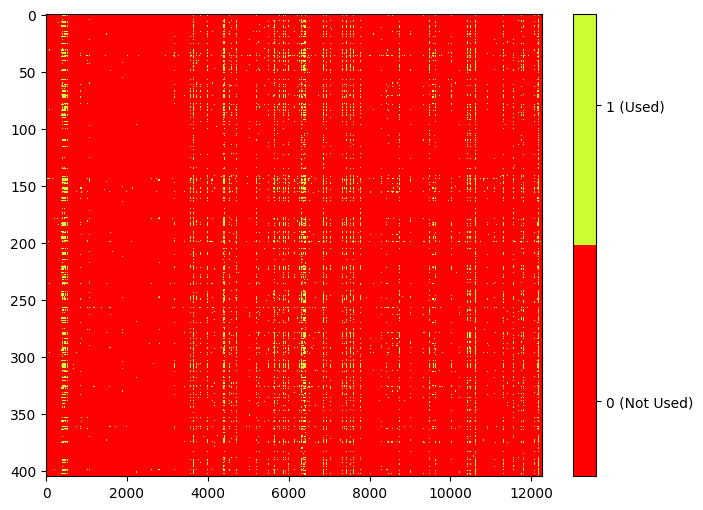

diffX: 13.716490680159223


In [69]:
M = ground_truth
O = obs_mask

reconstructed_matrix = collaborative_filtering(
    M=M,
    O=O,
    Otest=O,  # Use the same mask for testing in this case
    Mgt=M,
    lambdaNuc_factor=10,
    lambdaDF=1e1,
    max_iter=10,
    tol=1e-1
)

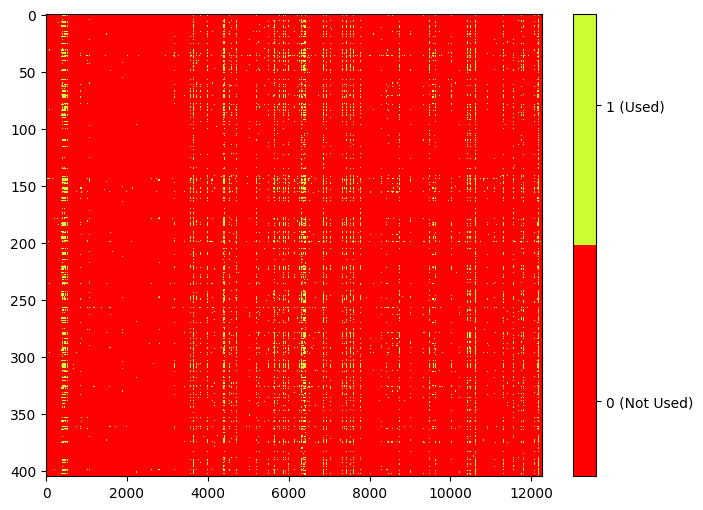

In [70]:
visualize_matrix(reconstructed_matrix)

In [71]:
reconstruction_error(ground_truth, reconstructed_matrix)

np.float64(0.09656015851678991)

## Page Rank

In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import json
from scipy.sparse import csr_matrix

dep_df = pd.read_csv("./dataset/dep-graph.csv")
graph = json.load(open("./dataset/dep-graph.json"))
feats = json.load(open(package_dependencies_json))

In [ ]:
def show_edge_info(df):
    sources = set(df['package'].unique())
    deps = set(df['dependency'].unique())
    pkg_space = sources.union(deps)
    
    print("Unique packages in packages column", len(sources))
    print("Unique packages in dependency column", len(deps))
    print("Total unique", len(pkg_space))

show_edge_info(dep_df)

In [ ]:
def show_node_info():
    no_out = {p for p, d in graph.items() if len(d) == 0}
    print("Nodes with 0 out-degree:", len(no_out))
    
    with_in = set()
    for dependencies in graph.values():
        with_in.update(dependencies)
    
    no_in = no_out - with_in
    
    print("Nodes with 0 in-degree and 0 out-degree:", len(no_in))
    
    json_str = json.dumps(json.load(open("./playground/dep-graph.json")))
    from_original = [p for p in no_in if json_str.find(p) != -1]
    print("Nodes with 0 in- and out-degree from source:", len(from_original))
    
show_node_info()

In [ ]:
# build adjacency matrix
G = nx.from_pandas_edgelist(dep_df, source='package', target='dependency', create_using=nx.Graph)
adj_matrix_sparse = csr_matrix(nx.adjacency_matrix(G))
print("Adjacency Matrix shape:", adj_matrix_sparse.shape)
print("G:", G)

In [ ]:
# build adjacency matrix using project data
from itertools import combinations
from collections import Counter
import math

def filter_top_by_download_count(packages, top=500):
    packages.sort(key=lambda x: feats[x]['download_count'], reverse=True)
    return packages[:top]

def filter_valid_packages(packages):
    return [p for p in packages if p in feats]

def create_co_dependency_graph(projects, limit=500, include_edge_weights=False):
    edges = []
    
    for project, data in tqdm(projects.items()):
        deps = [p for p in data.keys() if p in feats]
        deps = filter_top_by_download_count(deps, top=limit)
        deps = filter_valid_packages(deps)
        
        for dep1, dep2 in combinations(deps, 2):
            edges.append(tuple(sorted((dep1, dep2)))) 
    
    # Convert the set of edges to a list
    if not include_edge_weights:
        return list(edges)
    else:
        Counter(edges)

project_data = json.load(open("./GithubScrape/Data/40_Projects/append_dependencies_40_1.json"))
edges = create_co_dependency_graph(project_data, limit=100)
edge_df = pd.DataFrame(edges, columns=['from', 'to'])
edge_df

In [ ]:
edge_df = edge_df.drop_duplicates()
edge_df.to_csv("./dataset/edges.csv", index=False)

In [ ]:
print(len(edge_df))
sources = set(edge_df['from'].unique())
deps = set(edge_df['to'].unique())
pkg_space = sources.union(deps)

print("Unique packages in packages column", len(sources))
print("Unique packages in dependency column", len(deps))
print("Total unique", len(pkg_space))

In [ ]:
G = nx.from_edgelist(edges, create_using=nx.Graph)
adj_matrix_sparse = csr_matrix(nx.adjacency_matrix(G))
print("Adjacency Matrix shape:", adj_matrix_sparse.shape)
print("G:", G)

In [ ]:
# Perform Pagerank
ranks = nx.pagerank(G, alpha=0.85)
ranks = list(ranks.items())
ranks.sort(key=lambda x: x[1], reverse=True)
ranks[:10]

### Pagerank with Weighted Nodes

In [ ]:
weights = {p: data["download_count"] for p, data in feats.items()}
weights

In [ ]:
ranks = nx.pagerank(G, alpha=0.85, personalization=weights)
ranks = list(ranks.items())
ranks.sort(key=lambda x: x[1], reverse=True)
ranks[:20]

### Pagerank with Keywords

In [ ]:
# define a function to calculate similarity scores based on keywords
def jaccard_similarity(a, b):
    a = set(a)
    b = set(b)
    return len(a & b) / len(a | b)

def pagerank_keywords(keyword_list: list, features, top=100, weights=None):
    if len(keyword_list) > 0:
        personalization = {pkg: jaccard_similarity(features[pkg]["keywords"], keyword_list)  for pkg in G.nodes}
        if sum(personalization.values()) == 0:
            personalization = {pkg: 1 for pkg in features.keys()}
        
        scores = nx.pagerank(G, alpha=0.1, personalization=personalization, weight=weights)
        
    else:
        scores = nx.pagerank(G, alpha=0.1, weight=weights)
        
    ranks = list(scores.items())
    ranks.sort(key=lambda x: x[1], reverse=True)
    return ranks[:top]

pagerank_keywords([
        "admin",
        "admin-dashboard",
        "admin-template",
        "axios",
        "dashboard",
        "desktop",
        "element",
        "element-ui",
        "i18n",
        "management-system",
        "mock",
        "tinymce",
        "vue",
        "vue-admin",
        "vue-cli",
        "vuex",
        "webpack",
        "webpack4",
        "xlsx"
    ], feats)

####  Run tests to see how many of the top 100 packages predicted by pagerank are actually present as project dependencies

In [ ]:
project_data = json.load(open(project_dependencies_json))

In [ ]:
def test_pagerank(project_deps, package_feats, search_terms, weights=None):
    suggested_deps = [p for p,s in pagerank_keywords(search_terms, package_feats, weights=weights)]
    count = 0
    for d in suggested_deps:
        if d in project_deps:
            count += 1
    
    return count, suggested_deps
    
test_pagerank(project_data["gpt4free"].keys(), feats, ['chatbot', 'chatbots', 'chatgpt', 'chatgpt-4', 'chatgpt-api', 'chatgpt-free', 'chatgpt4', 'free-gpt', 'gpt', 'gpt-3', 'gpt-4', 'gpt3', 'gpt4', 'gpt4-api', 'language-model', 'openai', 'openai-api', 'openai-chatgpt', 'python', 'reverse-engineering'])

In [ ]:
project_df = pd.read_csv("./GithubScrape/Data/40_With_Description/github_40_projects_with_topics_4.csv")

def convert_str_to_list(string):
    string = string.strip()
    if not string.startswith("[") or not string.endswith("]"):
        return []
    
    string = string[1:-1].strip()
    
    if not string:
        return []
    
    keywords = [item.strip().strip("'").strip('"') for item in string.split(",")]
    
    return [keyword for keyword in keywords if keyword]

def test_pagerank_kewords_all_projects(project_data, project_df, weights=None):
    total = 0
    for i, r in project_df.iterrows():
        project = r['name']
        keywords = convert_str_to_list(r['topics'])
        if project in project_data:
            dependencies = project_data[project].keys()
            test_count, _ = test_pagerank(project_data[project], feats, keywords, weights=weights)
            print(f"{project:70}\t{test_count}/{len(dependencies)}")
            total += test_count
            
    print(f"----------\ntotal {total}")
    
    
test_pagerank_kewords_all_projects(project_data, project_df)

## Graph Content Filtering

In [ ]:
import json
import math
from collections import defaultdict
from datetime import datetime, timedelta
from typing import Union, List
import numpy as np
import pandas as pd
import requests
from tqdm.notebook import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt




In [ ]:
# UTILITY FUNCTIONS

def filter_valid_package_names(packages):
    packages = set(packages)
    remove = set()
    for package in packages:
        if (not package.startswith('@')) and (not package[0].islower()):
            remove.add(package)
                
    return packages - remove


def retryable(func, *args, max_retries=3, on_fail=None, **kwargs):
    for i in range(max_retries):
        try:
            return func(*args, **kwargs)
        except requests.exceptions.ConnectionError as e:
            print(
                f"[ERROR] Connection error {e} occurred for function {func} with args {args}, {kwargs}: attempt {i + 1}")
        except RuntimeError as e:
            print(f"[ERROR] Runtime error {e} occurred for function {func} with args {args}, {kwargs}: attempt {i + 1}")
            break

    return on_fail


def convert_time_to_epoch(timestamp):
    timestamp = timestamp.replace('Z', '+00:00')
    timestamp = datetime.fromisoformat(timestamp)
    return datetime.strftime(timestamp, '%s')


def save_data_as_json(data, filename):
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)
        

def load_data_from_json(filename):
    return json.load(open(filename, "r"))


def convert_str_to_list(string):
    string = string.strip()
    if not string.startswith("[") or not string.endswith("]"):
        return []
    
    string = string[1:-1].strip()
    
    if not string:
        return []
    
    keywords = [item.strip().strip("'").strip('"') for item in string.split(",")]
    
    return [keyword for keyword in keywords if keyword]


In [ ]:
# Function to fetch package data from NPM API

def fetch_package_data(package, base_url="https://registry.npmjs.org/"):
    res = requests.get(base_url + package)
    data = res.json()
    
    if res.status_code == 200:
        if 'dist-tags' not in data:
            print(f"{package} is unpublished")
            return {}
    
        latest_version = data["dist-tags"]["latest"]
        
        package_details = {
            "latest_version": latest_version,
            "keywords": data.get("keywords", []),
            "publish_time": convert_time_to_epoch(data["time"][latest_version]),
            "description": data.get("description", ""),
            "creation_date": data["time"]["created"],
            "number_of_versions": len(data["versions"]),
            "dependencies": data["versions"][latest_version].get("dependencies", {}), 
            "devDependencies": data["versions"][latest_version].get("devDependencies", {}), 
            "peerDependencies": data["versions"][latest_version].get("peerDependencies", {}), 
        }
        
        return package_details
    
    else:
        return -res.status_code

In [ ]:
# Function to concurrently fetch data for a list of packages

def fetch_package_list(packages, max_workers=10):
    package_feats = {}
    failed_packages = []
    
    with ThreadPoolExecutor() as executor:
        futures = { executor.submit(retryable, fetch_package_data, package, on_fail=-1): package for package in packages }
        
        for future in tqdm(as_completed(futures), total=len(futures)):
            package = futures[future]
            result = future.result()
            
            if type(result) is int and result < 0:
                failed_packages.append(package + '\n')
            elif result == {}:
                failed_packages.append(f'{package} is unpublished' + '\n')
            else:
                result["dependencies"] = list(result["dependencies"].keys()) if result["dependencies"] != {} else []
                package_feats[package] = result
    
    with open("./log.txt", "w") as f:
        print(f"Successfully fetched {len(package_feats)}/{len(packages)} packages. Check ./log.txt for failed packages.")
        f.writelines(failed_packages)
        
    return package_feats

In [ ]:
# Functions to load project data to build package space

def load_project_data(file="./GithubScrape/Data/60_topics_JS/append_dependencies_40_7.json"):
    data = json.load(open(file, "r"))
    for p, deps in data.items():
        data[p] = list(filter_valid_package_names(list(deps.keys())))
    
    return data


def build_package_space(projects):
    package_space = set()
    for project, deps in projects.items():
        package_space.update(deps)
        
    return package_space
        

In [ ]:
project_data = load_project_data()
package_list = build_package_space(project_data)

In [ ]:
package_data = fetch_package_list(package_list, max_workers=20)

In [ ]:
# Functions to get download counts in bulk or for single package

def get_download_counts_bulk(packages):
    url = f"https://api.npmjs.org/downloads/point/last-year/{','.join(packages)}"
    res = requests.get(url)
    
    if res.status_code == 200:
        data = res.json()
        return [(p, d['downloads']) for p,d in data.items()]
        
    else:
        print(f"[ERROR] failed for chunk {packages} with status code {res.status_code}")
        return -1
        
get_download_counts_bulk(["semver", "axios"])

def get_download_count(package):
    url = f"https://api.npmjs.org/downloads/point/last-year/{package}"
    res = requests.get(url)
    
    if res.status_code == 200:
        data = res.json()
        return data['downloads']
    
    else:
        print(f"[ERROR] failed for package {package} with status code {res.status_code}")
        return -1

In [ ]:
# Functions to divide packages into scoped and unscoped and get download counts

def fetch_download_counts_unscoped(packages, max_workers=5):
    chunks = []
    for i in range(0, len(packages), 128):
        chunks.append(packages[i:i + 128])
    print("Number of chunks for unscoped:", len(chunks))
    
    counts = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = { executor.submit(retryable, get_download_counts_bulk, chunk): chunk for chunk in chunks }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Unscoped packages"):
            res = future.result()
            if res != -1:
                counts += res
            
    return counts
    
def fetch_download_counts_scoped(packages, max_workers=5):
    counts = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = { executor.submit(retryable, get_download_count, package): package for package in packages }
        
        for future in tqdm(as_completed(futures), total=len(futures), desc="Scoped Packages"):
            res = future.result()
            if res != -1:
                counts.append((futures[future], res))
                
    return counts


def fetch_download_counts(packages, max_workers_unscoped=5, max_workers_scoped=5):
    scoped = []
    unscoped = []
    for package in packages:
        if package.find("@") != -1:
            scoped.append(package)
        else:
            unscoped.append(package)
    print(f'scoped: {len(scoped)}\tunscoped: {len(unscoped)}')
    
    counts = fetch_download_counts_unscoped(unscoped, max_workers=max_workers_unscoped)
    counts += fetch_download_counts_scoped(scoped, max_workers=max_workers_scoped)

    return counts

def update_download_counts(features_dict):
    counts = fetch_download_counts(list(features_dict.keys()), max_workers_scoped=10)
    for p, c in counts:
        features_dict[p]["download_count"] = c


In [ ]:
update_download_counts(package_data)

In [ ]:
save_data_as_json(package_data, package_features_cf_json)

In [ ]:
package_data = load_data_from_json(package_features_cf_json)

In [ ]:
def build_common_dependency_matrix_sparse(data):
    """
    Build a common dependency matrix using scipy sparse matrices for faster computation.

    Args:
        data (dict): A dictionary where keys are package names and values are dictionaries
                     containing 'dependencies' as a list of dependencies.

    Returns:
        csr_matrix: A sparse matrix where each cell (i, j) represents the number of common
                    dependencies between package i and package j.
        list: The sorted order of package names.
    """
    # Step 1: Extract package and dependency orders
    package_order = sorted(data.keys())
    
    dep_order = sorted(set(dep for feats in data.values() for dep in feats["dependencies"]))

    # Step 2: Build sparse binary dependency matrix
    rows, cols = [], []
    for i, package in enumerate(package_order):
        for dep in data[package]["dependencies"]:
            if dep in dep_order:
                rows.append(i)
                cols.append(dep_order.index(dep))
    
    # Create sparse matrix in CSR format
    num_packages = len(package_order)
    num_dependencies = len(dep_order)
    binary_matrix = csr_matrix((np.ones(len(rows)), (rows, cols)), shape=(num_packages, num_dependencies))

    # Step 3: Compute common dependency matrix using sparse dot product
    common_matrix = binary_matrix.dot(binary_matrix.T)

    return common_matrix, package_order

common_mat, pkg_order = build_common_dependency_matrix_sparse(package_data)

In [ ]:
def plot_large_sparse_heatmap(sparse_matrix, max_dim=500, title="Sparse Heatmap", threshold=None):
    """
    Visualize a large sparse matrix as a heatmap by downsampling and handling sparsity.

    Args:
        sparse_matrix (csr_matrix): The large sparse matrix to visualize.
        max_dim (int): Maximum dimension (rows/columns) to display in the heatmap.
                       The matrix is cropped to max_dim x max_dim for visualization.
        title (str): Title of the heatmap.
        threshold (float, optional): Minimum value to include in the heatmap.
                                      Values below this threshold will be set to 0.
    """
    # Step 1: Downsample the matrix for visualization
    if sparse_matrix.shape[0] > max_dim or sparse_matrix.shape[1] > max_dim:
        print(f"Matrix too large for direct visualization. Showing top {max_dim}x{max_dim} subset.")
        sparse_matrix = sparse_matrix[:max_dim, :max_dim]
    
    # Step 2: Convert sparse matrix to dense for visualization
    dense_matrix = sparse_matrix.toarray()

    # Step 5: Plot the heatmap
    plt.figure(figsize=(8, 8))
    im = plt.imshow(dense_matrix, cmap="jet", interpolation="nearest")
    cbar = plt.colorbar(im)
    cbar.set_label("Normalized Values")

    # Add title and axis labels
    plt.title(title)
    plt.xlabel("Columns")
    plt.ylabel("Rows")
    plt.tight_layout()

    # Display the plot
    plt.show()

plot_large_sparse_heatmap(common_mat, max_dim=100, threshold=0.01)


In [ ]:
from sentence_transformers import SentenceTransformer

def get_bert_embeddings_batch(data: List[Union[List[str], str]], model=None, batch_size=32, desc="Processing Batches") -> np.ndarray:
    """
    Convert a list of keywords or descriptions to BERT embeddings using batch processing.

    Args:
        data (list): A list of inputs where each item is either a list of keywords (strings) or a string (description).
        model (SentenceTransformer, optional): Preloaded BERT model for efficiency.
        batch_size (int): Number of items to process in a single batch.

    Returns:
        np.ndarray: A 2D NumPy array where each row is the embedding vector for the corresponding input.
    """
    # Load BERT model if not provided
    if model is None:
        model = SentenceTransformer('all-MiniLM-L6-v2')  # Lightweight and efficient BERT model

    # Preprocess the data: combine keywords into strings if necessary
    processed_data = []
    for item in data:
        if isinstance(item, list):  # If the input is a list of keywords
            if not item:  # Handle empty lists
                processed_data.append("")
            else:
                processed_data.append(" ".join(item))  # Combine keywords into a single string
        elif isinstance(item, str):  # If the input is already a string (description)
            processed_data.append(item.strip())
        else:
            raise ValueError("Each item in the input data must be either a list of strings or a single string.")

    # Handle empty input cases
    zero_vector = np.zeros(model.get_sentence_embedding_dimension())
    if all(not item for item in processed_data):  # All inputs are empty
        return np.array([zero_vector] * len(data))

    # Compute embeddings in batches
    embeddings = []
    num_batches = (len(processed_data) + batch_size - 1) // batch_size  # Calculate total number of batches
    for i in tqdm(range(0, len(processed_data), batch_size), desc=desc, total=num_batches):
        batch = processed_data[i:i + batch_size]
        batch_embeddings = model.encode(batch)  # Batch encoding
        embeddings.extend(batch_embeddings)

    return np.array(embeddings)


In [ ]:
def get_embeddings_for_features(data, feats):
    order = sorted(data.keys())
    
    result = {
        "key_order": order,
    }
    
    for feat in feats:
        if feat == "name":
            embeddings = get_bert_embeddings_batch(order, desc="Name Batches")
        else:
            embeddings = get_bert_embeddings_batch(order, desc=f"{feat} Batches")
        result[f"{feat}_embeddings"] = embeddings
        
    return result
    
embedding_data = get_embeddings_for_features(package_data, ["name", "keywords", "description"])

In [ ]:
# Step 2 - Convert Dictionary to NumPy Matrix to get Feature Matrix

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# convert download counts to a normalized array
downloads = np.array([package_data[p]["download_count"] for p in embedding_data["key_order"]])
downloads = scaler.fit_transform(downloads.reshape(-1, 1))
print(downloads[:10])

feature_matrix = np.column_stack((downloads, embedding_data["name_embeddings"], embedding_data["keywords_embeddings"], embedding_data["description_embeddings"]))
print(feature_matrix.shape)

In [ ]:
# Step 4 - Compute Pairwise distances

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
similarity_matrix = cosine_similarity(feature_matrix)

In [ ]:
similarity_matrix.shape

In [ ]:
print(similarity_matrix[:5, :5])

In [ ]:
# Step 5 - construct KNN graph

import numpy as np
import networkx as nx

def create_knn_graph(score_matrix: np.ndarray, k: int) -> nx.Graph:
    """
    Create a KNN graph from a distance matrix.

    Args:
        score_matrix (np.ndarray): A 2D array where element (i, j) represents the similarity score between package i and j.
        k (int): The number of nearest neighbors to connect for each node.

    Returns:
        nx.Graph: A KNN graph where nodes represent packages, and edges connect nearest neighbors.
    """
    # Step 1: Initialize the graph
    num_nodes = score_matrix.shape[0]
    knn_graph = nx.Graph()

    # Step 2: Add nodes to the graph
    knn_graph.add_nodes_from(range(num_nodes))

    # Step 3: Find the k-nearest neighbors for each node
    for i in range(num_nodes):
        # Get the scores for the current node
        scores = score_matrix[i]
        
        # Exclude self-scores and find the k smallest distances
        nearest_neighbors = np.argsort(scores)[-k-1:-1] # Skip the first one (itself)
        nearest_neighbors = nearest_neighbors.reshape((-1, 1))
        
        # Add edges to the graph
        for neighbor in nearest_neighbors:
            if neighbor[0] != i:
                knn_graph.add_edge(i, neighbor[0], weight=1)

    return knn_graph


In [ ]:
package_knn_graph = create_knn_graph(similarity_matrix, 5)
print("Number of nodes:",len(package_knn_graph.nodes))
print("Number of edges:",len(package_knn_graph.edges))

In [ ]:
import networkx as nx

def visualize_knn_graph(graph, node_subset=None, title="KNN Graph", node_size=50, show_labels=True):
    """
    Visualize a KNN graph using NetworkX and Matplotlib.

    Args:
        graph (nx.Graph): The KNN graph to visualize.
        node_subset (list, optional): Subset of nodes to visualize (default: all nodes).
        title (str): Title for the plot.
        node_size (int): Size of the nodes in the plot.

    Returns:
        None
    """
    # Step 1: Subset the graph if needed
    if node_subset:
        subgraph = graph.subgraph(node_subset)
    else:
        subgraph = graph

    # Step 2: Choose a layout
    pos = nx.spring_layout(subgraph, seed=42)  # Spring layout for visually appealing positions

    # Step 3: Draw the graph
    plt.figure(figsize=(6, 6))
    nx.draw(
        subgraph,
        pos,
        with_labels=show_labels,
        node_size=node_size,
        font_size=8,
        edge_color="gray",
        node_color="skyblue",
    )

    # Step 4: Add title
    plt.title(title)
    plt.show()


In [ ]:
visualize_knn_graph(package_knn_graph, node_subset=list(range(500)), title="KNN Graph (Subset)", node_size=20, show_labels=False)

In [ ]:
def compute_similarity_scores(data, numerical_features: list, text_features: list):
    # embeddings = get_embeddings_for_features(data, text_features)
    order = sorted(data.keys())
    nf = len(numerical_features)
    nt = len(text_features)
    
    # Compute scores for numerical features
    scaler = MaxAbsScaler()
    
    num_feat_vecs = []
    for ft in numerical_features:
        arr = np.array([data[p][ft] for p in order])
        num_feat_vecs.append(arr.reshape(-1,1))
        
    num_feat_vecs = np.hstack(num_feat_vecs)
    num_feat_vecs = scaler.fit_transform(num_feat_vecs)
    num_feat_vec_similarity = cosine_similarity(num_feat_vecs)
    
    # Compute scores for text features
    embeddings = get_embeddings_for_features(data, text_features)
    del embeddings["key_order"]
    text_feat_vec = np.hstack([embeddings[f"{ft}_embeddings"] for ft in text_features])
    text_feat_vec_similarity = cosine_similarity(text_feat_vec)
    
    # Take weighted sum
    wt = 1.0 / (nf + nt)
    
    scores = (nf * wt * num_feat_vec_similarity) + (nt * wt * text_feat_vec_similarity)
    
    return scores

In [ ]:
similarity_matrix = compute_similarity_scores(package_data, numerical_features=["download_count"], text_features=["name", "keywords", "description"])

In [ ]:
package_knn_graph = create_knn_graph(similarity_matrix, 5)
visualize_knn_graph(package_knn_graph, node_subset=list(range(500)), title="KNN Graph (Subset)", node_size=20, show_labels=False)

#### Build KNN graph for projects

In [ ]:
# Step 0 - load data and create a dict

filter_project_list = project_data.keys()
project_df = pd.read_csv("./GithubScrape/Data/60_topics_JS/github_40_projects_with_topics_7.csv")
project_df = project_df[project_df['name'].isin(filter_project_list)]
project_df.drop_duplicates("name", keep='last', inplace=True)
project_df.set_index("name", inplace=True)
project_feats = project_df.to_dict(orient="index")

for p, f in project_feats.items():
    project_feats[p]["topics"] = convert_str_to_list(f["topics"])

In [ ]:
# Step 1 - get embeddings for project text features

project_embeddings = get_embeddings_for_features(project_data, ["name", "topics", "description"])

In [ ]:
print(project_embeddings["name_embeddings"].shape)# Step 2 - combine into feature matrix
scaler = MaxAbsScaler()

size_feat = scaler.fit_transform(np.array([project_feats[p]["size"] for p in project_embeddings["key_order"]]).reshape(-1,1))
star_feat = scaler.fit_transform(np.array([project_feats[p]["stars"] for p in project_embeddings["key_order"]]).reshape(-1,1))
fork_feat = scaler.fit_transform(np.array([project_feats[p]["forks"] for p in project_embeddings["key_order"]]).reshape(-1,1))
print(size_feat.shape)
print(star_feat.shape)
print(fork_feat.shape)

project_feature_matrix = np.column_stack((size_feat, star_feat, fork_feat, project_embeddings["name_embeddings"], project_embeddings["topics_embeddings"], project_embeddings["description_embeddings"]))

print(project_feature_matrix.shape)

In [ ]:
# Step 3 - compute pairwise similarity
project_similarity_matrix = cosine_similarity(project_feature_matrix)
print(project_similarity_matrix[:5, :5])
print(project_similarity_matrix.shape)

In [ ]:
# Step 4 - construct KNN Graph
project_knn_graph = create_knn_graph(project_similarity_matrix, 3)

In [ ]:
visualize_knn_graph(project_knn_graph, show_labels=False, node_size=10)

In [ ]:
def compute_similarity_scores(data, numerical_features: list, text_features: list):
    # embeddings = get_embeddings_for_features(data, text_features)
    order = sorted(data.keys())
    nf = len(numerical_features)
    nt = len(text_features)
    
    # Compute scores for numerical features
    scaler = MaxAbsScaler()
    
    num_feat_vecs = []
    for ft in numerical_features:
        arr = np.array([data[p][ft] for p in order])
        num_feat_vecs.append(arr.reshape(-1,1))
        
    num_feat_vecs = np.hstack(num_feat_vecs)
    num_feat_vecs = scaler.fit_transform(num_feat_vecs)
    num_feat_vec_similarity = cosine_similarity(num_feat_vecs)
    print(num_feat_vec_similarity[:5, :5])
    
    # Compute scores for text features
    embeddings = get_embeddings_for_features(data, text_features)
    del embeddings["key_order"]
    text_feat_vec = np.hstack([embeddings[f"{ft}_embeddings"] for ft in text_features])
    text_feat_vec_similarity = cosine_similarity(text_feat_vec)
    print(text_feat_vec_similarity[:5, :5])
    
    # Take weighted sum
    wt = 1.0 / (nf + nt)
    print(wt)
    
    scores = (nf * wt * num_feat_vec_similarity) + (nt * wt * text_feat_vec_similarity)
    print(scores[:5, :5])
    print(type(scores))
    
    return scores

In [ ]:
project_similarity_matrix = compute_similarity_scores(project_feats, numerical_features=["size", "stars", "forks"], text_features=["name", "topics", "description"])

In [ ]:
project_knn_graph = create_knn_graph(project_similarity_matrix, 3)

In [ ]:
visualize_knn_graph(project_knn_graph, show_labels=False, node_size=10)

## Build Ground Truth Matrix

In [ ]:
def clean_project_data(data, valid):
    for project, deps in data.items():
        data[project] = [p for p in deps if p in valid]
        
        
def create_package_list(data):
    packages = set()
    for deps in data.values():
        packages.update(deps)
    return list(packages)
    

clean_project_data(project_data, valid=package_data.keys())

In [ ]:
def create_ground_truth_matrix(data):
    package_list = create_package_list(project_data)
    package_list.sort()
    project_names = sorted(data.keys())
    
    gt_mat = np.full((len(project_names), len(package_list)), 0)
    
    for i, project in enumerate(project_names):
        for pkg in data[project]:
            if pkg in package_list:
                j = package_list.index(pkg)
                gt_mat[i, j] = 1
                    
    return gt_mat, package_list, project_names
                
ground_truth, package_order, project_order = create_ground_truth_matrix(project_data)

In [ ]:
from matplotlib.colors import ListedColormap

def visualize_matrix(mat, mask=None, colors=('#023047', 'red', '#ccff33')):
    if mask is None:
        mat_display = mat
        cmap = ListedColormap(colors[1:])
        yticks = [0, 1]
        yticklabels = ['0 (Not Used)', '1 (Used)']
    else:
        mat_display = mat.copy()
        mat_display[mask == 0] = -1
        cmap = ListedColormap(colors)
        yticks = [-1, 0, 1]
        yticklabels = ['-1 (Blank)', '0 (Not Used)', '1 (Used)']
        
    plt.figure(figsize=(8, 6))
    plt.imshow(mat_display, cmap=cmap, interpolation='nearest', aspect='auto')
    
    cbar = plt.colorbar(ticks=yticks)
    cbar.ax.set_yticklabels(yticklabels)
    
    plt.show()
    
visualize_matrix(ground_truth)

In [ ]:
np.random.seed(42)

def create_observation_mask(M, mask_percentage):
    n, m = M.shape
    total_entries = n * m
    mask_count = int(mask_percentage * total_entries / 100)

    # Randomly shuffle indices
    all_indices = np.arange(total_entries)
    np.random.shuffle(all_indices)

    # Select indices to retain
    mask_indices = all_indices[:mask_count]

    # Create observation mask
    O = np.ones_like(M, dtype=int)
    O.flat[mask_indices] = 0
    return O


In [ ]:
obs_mask = create_observation_mask(ground_truth, mask_percentage=90)
visualize_matrix(ground_truth, mask=obs_mask)

## Perform Content Filtering Algorithm

In [ ]:
def graph_laplacian(W, normalized=True):
    W = W.astype(np.float64)
    
    # Degree vector
    d = W.sum(axis=0, dtype=W.dtype)
    
    # Laplacian matrix
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        L = D - W
    else:
        d += np.spacing(np.array(0, W.dtype)) # d += epsilon
        d = 1.0 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(), 0)
        I = scipy.sparse.identity(d.size, dtype=W.dtype)
        L = I - D * W * D
    return L

In [ ]:
from scipy.sparse.linalg import LinearOperator, cg
from scipy.sparse import diags
import numpy as np
import scipy

def content_filtering_with_dirichlet_linear_operator(O, M, Wrow, Wcol, lambdaDir=1e-1, lambdaDF=1e2, alpha=0.02, tol=1e-6, maxiter=100):
    """
    Perform content filtering with Dirichlet energy regularization using LinearOperator to avoid explicit Kronecker products.

    Args:
        O (np.ndarray): Observation mask matrix (binary, shape: [n, m]).
        M (np.ndarray): Observed values matrix (shape: [n, m]).
        Wrow (csr_matrix): Weight matrix for rows (shape: [n, n]).
        Wcol (csr_matrix): Weight matrix for columns (shape: [m, m]).
        lambdaDir (float): Regularization parameter for the graph Laplacian.
        lambdaDF (float): Regularization parameter for observed values.
        alpha (float): Weighting parameter between row and column Laplacians.
        tol (float): Tolerance for the Conjugate Gradient solver.
        maxiter (int): Maximum iterations for the Conjugate Gradient solver.

    Returns:
        np.ndarray: The completed matrix (shape: [n, m]).
    """
    # Step 1: Compute graph Laplacians
    Lr = graph_laplacian(Wrow)  # Row graph Laplacian (n x n)
    Lc = graph_laplacian(Wcol)  # Column graph Laplacian (m x m)

    n, m = O.shape  # Dimensions of the input matrices
    print(f"n = {n}, m = {m}")
    print(f"Lr.shape = {Lr.shape}")
    print(f"Lc.shape = {Lc.shape}")
    print("Lr.nnz:", Lr.nnz)  # Non-zero entries in Lr
    print("Lc.nnz:", Lc.nnz)  # Non-zero entries in Lc


    # Step 2: Define a LinearOperator for A
    def apply_A(x):
        """
        Apply the matrix-vector product A @ x without explicitly constructing A.
        """
        X = x.reshape((n, m))  # Reshape x into (n, m) matrix
        row_part = (1.0 - alpha) * (Lr @ X)  # Apply row Laplacian
        col_part = alpha * (X @ Lc.T)  # Apply column Laplacian
        result = lambdaDir * (row_part + col_part)  # Combine with lambdaDir
        vecO = np.ravel(O)  # Flatten observation mask
        result = result.ravel() + lambdaDF * vecO * x  # Add regularization term
        return result

    A = LinearOperator(
        shape=(n * m, n * m),  # Full matrix shape
        matvec=apply_A,  # Function to compute A @ x
        dtype=np.float64
    )

    # Step 3: Prepare the right-hand side vector b
    vecM = np.ravel(M)  # Flatten observed values matrix
    vecO = np.ravel(O)  # Flatten observation mask
    matO = diags(vecO, 0, shape=(n * m, n * m), dtype=np.float64)  # Diagonal matrix for observed values
    b = lambdaDF * (matO @ vecM)  # Right-hand side vector

    print(f"vecO.shape = {vecO.shape}")
    print(f"matO.shape = {matO.shape}")

    # Step 4: Solve Ax = b using Conjugate Gradient
    x, info = cg(A, b, x0=np.zeros_like(b), tol=tol, maxiter=maxiter)

    if info != 0:
        raise ValueError(f"Conjugate Gradient solver did not converge (info={info}).")

    # Step 5: Reshape solution back to matrix form
    X = x.reshape((n, m))  # Reshape x into (n, m) matrix

    return X


In [ ]:
# Set params
O = obs_mask
M = ground_truth
Wrow = csr_matrix(nx.adjacency_matrix(project_knn_graph))
Wcol = csr_matrix(nx.adjacency_matrix(package_knn_graph))

lambdaDir=1e-1
lambdaDF=1e3
alpha=0.02
tol=1e-9

In [ ]:
reconstructed_matrix = content_filtering_with_dirichlet_linear_operator(O, M, Wrow, Wcol, lambdaDir=lambdaDir, lambdaDF=lambdaDF, tol=tol, alpha=alpha, maxiter=1000)

In [ ]:
visualize_matrix(reconstructed_matrix)

In [ ]:
def reconstruction_error(original, test):
    
    # Apply the mask to calculate the error only on specified elements
    difference = original - test
    squared_error = np.square(difference)
    mean_squared_error = np.mean(squared_error)
    rmse = np.sqrt(mean_squared_error)
    
    return rmse

reconstruction_error(ground_truth, reconstructed_matrix)